# Meta-analytic functional decoding

## Continuous decoding

In this notebook, we applied meta-analytic functional decoding using the [NiMARE](https://nimare.readthedocs.io/en/stable/decoding.html). 

Specifically, we applied a continuous, correlation-based decoding approach to unthresholded meta-analytic statistical maps, assessing their similarity to term-based meta-analytic maps derived from large-scale databases such as Neurosynth.

In [ ]:
# Import necessary modules
import os
import sys
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import nibabel as nib

from nilearn import image, plotting, datasets
from nilearn.maskers import NiftiSpheresMasker

import nimare
from nimare.dataset import Dataset
from nimare.decode import discrete, continuous
from nimare.stats import pearson
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nilearn.masking import _unmask_3d

# print the current working directory
# print(os.getcwd())

In [ ]:
# get neurosynth data
databases = nimare.extract.fetch_neurosynth(data_dir='../Data')[0]

# convert to NiMARE dataset (Note: This can take a while!)
ds = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=databases['coordinates'],
    metadata_file=databases['metadata'],
    annotations_files=databases['features']
    )

In [ ]:
ds.coordinates

In [ ]:
# fetch cognitive atlas terms

base_url = "https://www.cognitiveatlas.org/api/v-alpha"

# Fetch concepts and tasks from Cognitive Atlas API
concepts = requests.get(f"{base_url}/concept?format=json").json()
tasks = requests.get(f"{base_url}/task?format=json").json()

# Collect term names (lowercase for matching)
cognitive_terms = [c["name"].lower() for c in concepts] + \
                  [t["name"].lower() for t in tasks]

print(f"Fetched {len(cognitive_terms)} cognitive terms from Cognitive Atlas.")


In [ ]:
# filter nimare annotations
# keep study identifier plus cognitive atlas–matched terms
terms_to_keep = ["id"] + [
    col for col in ds.annotations.columns
    if col.split("__")[-1].lower() in cognitive_terms
]

ds.annotations = ds.annotations[terms_to_keep]

print(f"Remaining features after filtering: {len(ds.annotations.columns) - 1}")

In [ ]:
# ensure required identifier columns exist

if "study_id" not in ds.annotations.columns:
    ds.annotations["study_id"] = ds.annotations["id"]

if "contrast_id" not in ds.annotations.columns:
    ds.annotations["contrast_id"] = ds.annotations["id"]


In [ ]:
# Continuous functional decoding
zmap_path = (
    "../Output/1_ALE/"
    "patient_minus_control_z.nii.gz"
)

print(f"Running continuous decoding for:\n{zmap_path}")

In [ ]:
target_img = nib.load(zmap_path)


In [ ]:
# define decoder parameters

decoder = continuous.CorrelationDecoder(
    frequency_threshold=0.001
)

decoder.fit(ds)
pat_minus_con_results = decoder.transform(target_img)
pat_minus_con_results.head()

pat_minus_con_results.to_csv("../Output/4_Decoding/patient_minus_control.csv", index=True)

# Visualization 


## Plot radar figure


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_elegant_contrast_radar(main_file, output_name='Contrast'):
    # 1. 数据提取
    df_main = pd.read_csv(main_file)
    df_main['feature'] = df_main['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)
    
    # 剔除解剖词
    exclude = ['triangularis', 'frontal', 'pars', 'gyrus', 'inferior', 'cortex', 'brain', 'area']
    df_clean = df_main[~df_main['feature'].str.contains('|'.join(exclude), case=False)]

    # 分别提取 Control 正向最强 和 Patient (负向) 最强
    # 注意：在 contrast.csv 中，负值代表 Patient > Control
    df_control = df_clean.sort_values(by='r', ascending=False).head(8)
    df_patient = df_clean.sort_values(by='r', ascending=True).head(8).copy()
    df_patient['abs_r'] = df_patient['r'].abs() # 取绝对值用于绘图

    # 合并标签并去重
    labels = list(dict.fromkeys(list(df_patient['feature']) + list(df_control['feature'])))
    num_vars = len(labels)

    # 准备两个序列的数据：对齐到相同的 labels 上
    # 如果某一组在某个标签上没有值，给一个极小值 0.005 保持图形圆润
    val_p = [dict(zip(df_patient['feature'], df_patient['abs_r'])).get(l, 0.005) for l in labels]
    val_c = [dict(zip(df_control['feature'], df_control['r'])).get(l, 0.005) for l in labels]

    # 闭合环路
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    val_p += val_p[:1]
    val_c += val_c[:1]
    angles += angles[:1]

    # 2. 绘图设置
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 莫兰迪配色 (淡红与淡蓝)
    p_color = '#FB9A99' # 淡红 (Patient)
    c_color = '#A6CEE3' # 淡蓝 (Control)

    # 绘制层叠序列
    # Patient 序列
    ax.plot(angles, val_p, color='#E31A1C', linewidth=1.2, alpha=0.7)
    ax.fill(angles, val_p, color=p_color, alpha=0.4, label='Patient')

    # Control 序列
    ax.plot(angles, val_c, color='#1F78B4', linewidth=1.2, alpha=0.7)
    ax.fill(angles, val_c, color=c_color, alpha=0.4, label='Control')

    # 3. 视觉精修
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10, fontweight='500')
    
    # 隐藏不必要的元素，让图更清爽

    # ax.grid(color='#EEEEEE', linestyle='-', linewidth=0.5) # 极淡网格
    ax.grid(True, linestyle='--', alpha=0.3)

    # 设置图例在下方
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


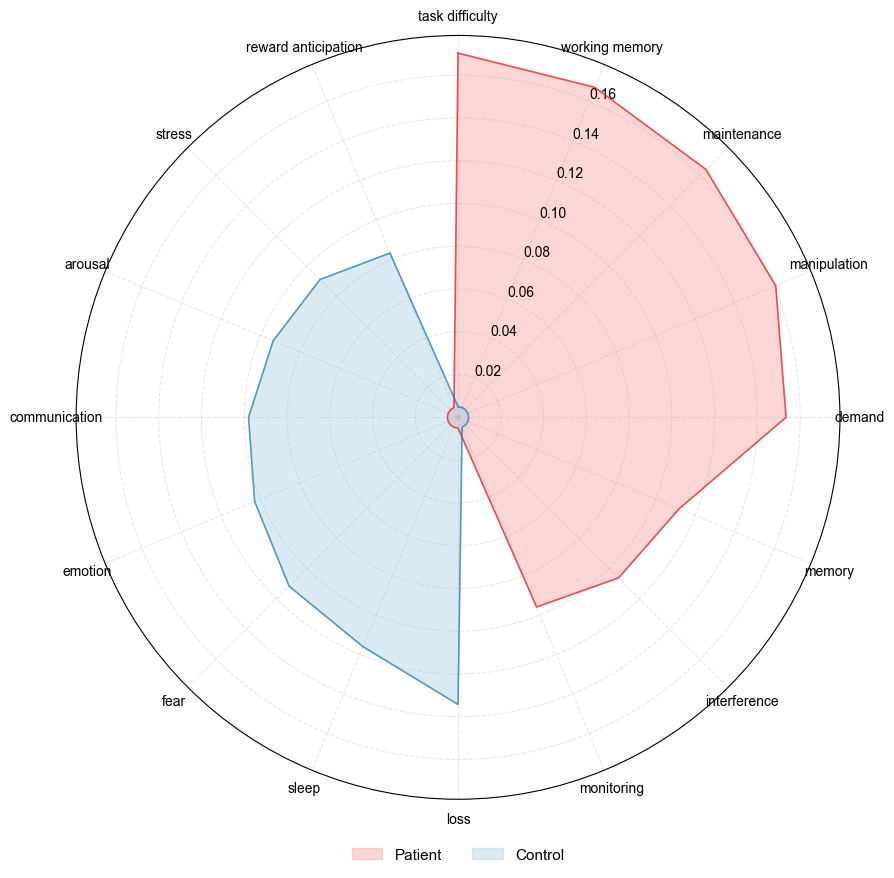

In [56]:
# 运行代码
plot_elegant_contrast_radar('../Output/4_Decoding/contrast.csv')

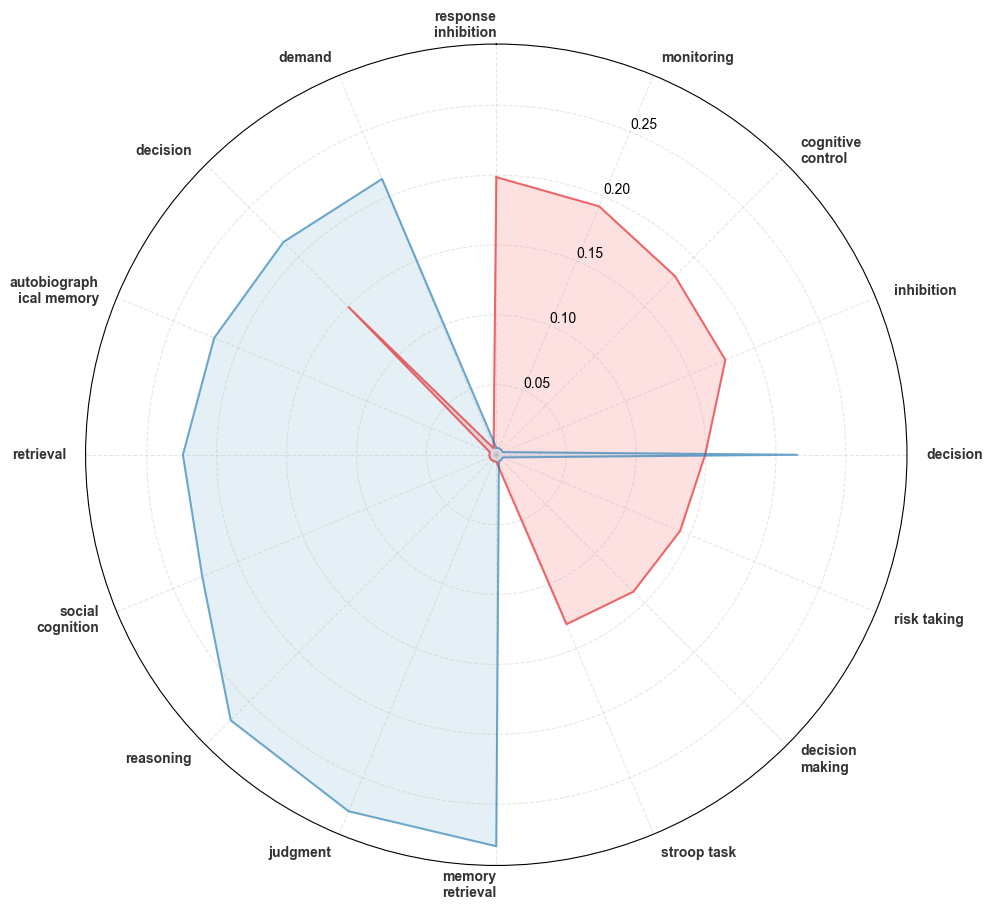

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

def plot_paper_style_radar(patient_file, control_file, output_name='decoding'):
    # 1. 数据预处理与标签清洗
    def get_top_features(file):
        df = pd.read_csv(file)
        df['feature'] = df['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)
        # 换行处理：为了美观，将长词分成两行
        df['feature'] = df['feature'].apply(lambda x: "\n".join(textwrap.wrap(x, 12)))
        exclude = ['triangularis', 'frontal', 'pars', 'gyrus', 'inferior', 'cortex', 'brain']
        df = df[~df['feature'].str.contains('|'.join(exclude), case=False)]
        return df[df['r'] > 0].sort_values('r', ascending=False).head(8)

    df_p = get_top_features(patient_file)
    df_c = get_top_features(control_file)

    # 按照语义顺序排列标签：Patient特征在前，Control特征在后
    # 这样雷达图的左半球和右半球会有明显的“功能分区”，就像Feng的文章一样
    labels = list(df_p['feature']) + list(df_c['feature'])
    num_vars = len(labels)

    # 对齐数据并给0值微小偏移 (0.005) 以保持图形圆润
    val_p = [dict(zip(df_p['feature'], df_p['r'])).get(l, 0.005) for l in labels]
    val_c = [dict(zip(df_c['feature'], df_c['r'])).get(l, 0.005) for l in labels]

    # 闭合环路
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    val_p += val_p[:1]; val_c += val_c[:1]; angles += angles[:1]

    # 2. 绘图设置 (柔和配色方案)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 绘制序列 (降低透明度，模仿论文质感)
    ax.plot(angles, val_p, color='#E31A1C', linewidth=1.5, alpha=0.6)
    ax.fill(angles, val_p, color='#FB9A99', alpha=0.3, label='Patients > Controls')

    ax.plot(angles, val_c, color='#1F78B4', linewidth=1.5, alpha=0.6)
    ax.fill(angles, val_c, color='#A6CEE3', alpha=0.3, label='Controls > Patients')

    # 3. 标签美化 (关键步)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10, fontweight='bold', color='#333333')
    
    # 手动调整标签位置，防止和图形重叠
    for label, angle in zip(ax.get_xticklabels(), angles):
        if 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # 移除外圈刻度和坐标线，保持简洁
    # ax.grid(color='#EEEEEE', linestyle='-', linewidth=0.5) # 极淡网格
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 执行绘图
plot_paper_style_radar('../Output/4_Decoding/patient_minus_control.csv', '../Output/4_Decoding/control_minus_patient.csv')